In [1]:
%load_ext autoreload
%autoreload 2

Stable diffusion from scratch

Generación de imágenes a partir de texto.

Empezaremos con un modelo que nos permita generar imágenes. Usaremos MNIST.

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

X.shape, y.shape

((70000, 784), (70000,))

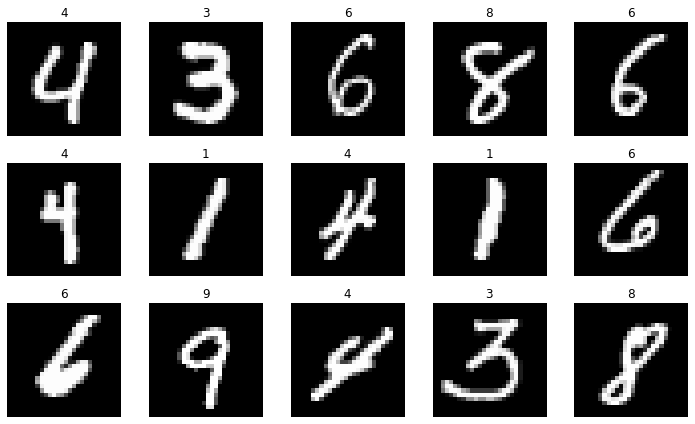

In [3]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        img = X.values[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y[ix])
plt.tight_layout()
plt.show()

Usaremos unet como modelo

In [4]:
from unet import UNet
import torch

model = UNet()
output = model(torch.randn(10, 1, 28, 28))
output.shape

torch.Size([10, 1, 28, 28])

Durante el entrenamiento añadiremos ruido a las imágenes de entrada. El objetivo del modelo será predecir el ruido añadido, de manera que si lo restamos a la imagen de entrada obtendremos la imagen original. 

In [128]:
import numpy as np 

class Dataset(torch.utils.data.Dataset):
	def __init__(self, X):
		self.X = (X / 255.).astype(np.float32)

	def __len__(self):
		return len(self.X)
	def __getitem__(self, ix):
		im = self.X[ix]
		im = torch.from_numpy(im).reshape(1, 28, 28)
		noise = torch.randn(1, 28, 28)
		return im, noise

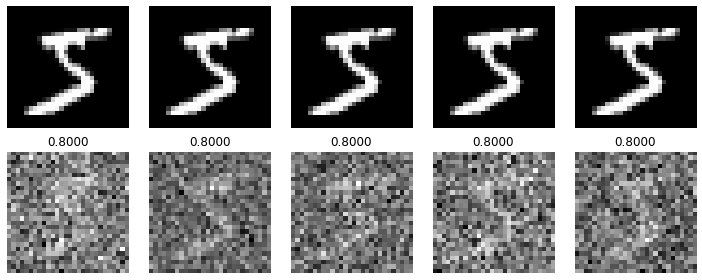

In [133]:
ds = Dataset(X.values)

ix = 0#random.randint(0, len(X)-1)
r, c = 2, 5
fig = plt.figure(figsize=(2*c, 2*r))
std=0.8
for _c in range(c):
	img, noise = ds[ix]
	plt.subplot(r, c, + _c + 1)
	plt.imshow(img[0], cmap='gray')
	plt.axis("off")
	plt.subplot(r, c, c + _c + 1)
	plt.imshow(img[0] + noise[0]*std, cmap='gray')
	plt.axis("off")
	# plt.title(f'{std.item():.4f}')
	plt.title(f'{std:.4f}')
plt.tight_layout()
plt.show()

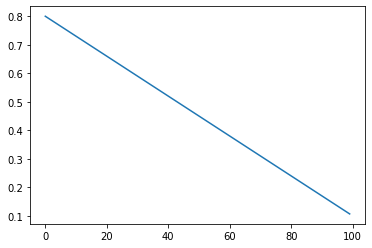

In [136]:
std = lambda epoch, max_epochs: 0.8 - 0.7 * epoch / max_epochs

max_epochs = 100
epochs = list(range(max_epochs))

plt.plot(epochs, [std(e, max_epochs) for e in epochs])
plt.show()

In [138]:
import tqdm 

EPOCHS = 100
BATCH_SIZE = 32

ds = Dataset(X.values[y.values == '3'])
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
model = UNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# im, noise, _ = next(iter(dl))
# im, noise = im.cuda(), noise.cuda()

model.train()
# pb = tqdm.tqdm(range(1, EPOCHS+1))
for epoch in range(1, EPOCHS+1):
# for epoch in pb:
	pb = tqdm.tqdm(dl)
	losses = []
	for im, noise in pb:
		im = im.cuda()
		noise = noise.cuda() * std(epoch, EPOCHS)
		output = model(im + noise)
		loss = torch.nn.functional.mse_loss(output, noise)
		loss.backward()
		optimizer.step()
		optimizer.zero_grad()
		losses.append(loss.item())
		pb.set_description(f'Epoch {epoch}/{EPOCHS} loss {np.mean(losses):.5f}')

Epoch 100/100 loss 0.00084: 100%|██████████| 224/224 [00:02<00:00, 83.06it/s]


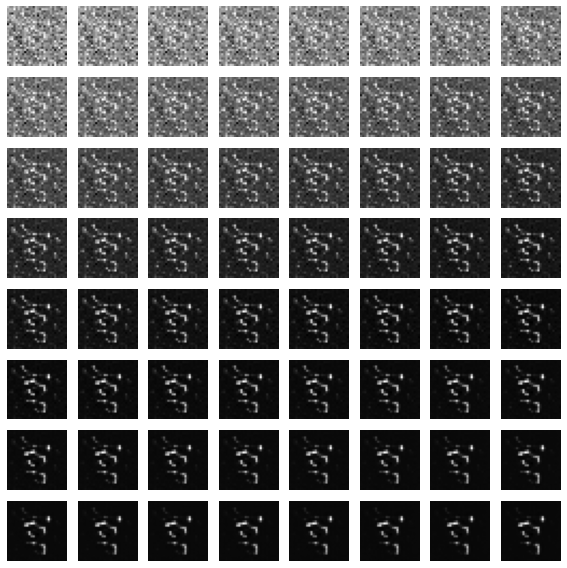

In [141]:
ITS = 64
C = 0.1

model.eval()

input = torch.randn(1, 1, 28, 28).cuda() * 0.5

# ix = random.randint(0, len(ds)-1)
# im, noise, _ = ds[ix]
# input = im.cuda().unsqueeze(0) + noise.cuda().unsqueeze(0)

r, c = int(ITS**0.5), int(ITS**0.5)
fig = plt.figure(figsize=(c, r))
for it in range(1,ITS+1):
	ax = plt.subplot(r, c, it)
	ax.imshow(input[0][0].cpu().numpy(), cmap='gray')
	ax.axis("off")
	with torch.no_grad():
		output = model(input)
	input = input - output * C
plt.tight_layout()
plt.show()

Problemas:

- how to add noise during training? how to remove noise during inference?
- imágenes de alta resolución -> entrenar autoencoder y luego unet solo en latent features